In [1]:
import os
import cv2
import easyocr
import torch
import matplotlib.pyplot as plt
%matplotlib inline

### Setup paths

In [14]:
ROOT = os.path.abspath("..")

PATHS = {
    "data": os.path.join(ROOT, "data"),
    "models": os.path.join(ROOT, "models"),
}
DATA = {
    "img00" : os.path.join(PATHS["data"], "car00.webp"),
    "img01" : os.path.join(PATHS["data"], "car01.webp"),
    "img02" : os.path.join(PATHS["data"], "car02.jpg"),
    "img03" : os.path.join(PATHS["data"], "car03.jpg"),
    "img04" : os.path.join(PATHS["data"], "car04.jpg"),
    "video" : os.path.join(PATHS["data"], "video.mp4"),
}

MODELS = {
    "plates_pt" : os.path.join(PATHS["models"], "plates.pt"),
    "plates_n_pt" : os.path.join(PATHS["models"], "plates_n.pt"),
    "plates_onnx" : os.path.join(PATHS["models"], "plates.onnx"),
    "platesv8_pt" : os.path.join(PATHS["models"], "plates_yolov8.pt"),
    "platesv8_onnx" : os.path.join(PATHS["models"], "plates_yolov8.onnx"),
}

SELECTED_MODEL = MODELS["plates_n_pt"]
SELECTED_IMAGE = DATA["img02"]

In [16]:
net = cv2.dnn.readNetFromONNX(MODELS["platesv8_onnx"])

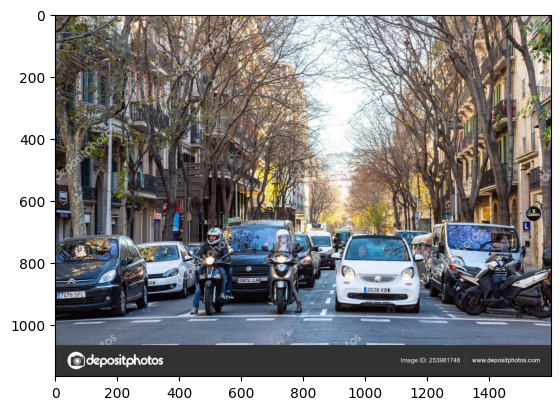

In [17]:
image = cv2.cvtColor(cv2.imread(SELECTED_IMAGE), cv2.COLOR_BGR2RGB)
height, width = image.shape[:2]
plt.imshow(image)
plt.show()

In [18]:
blob = cv2.dnn.blobFromImage(image, 1/255, (640, 640), swapRB=False, crop=False)
net.setInput(blob)
outputs = net.forward()

In [28]:
outputs.shape

(1, 5, 8400)

In [20]:
idx = outputs[0][:, 4] > 0.80
idx.sum()

4

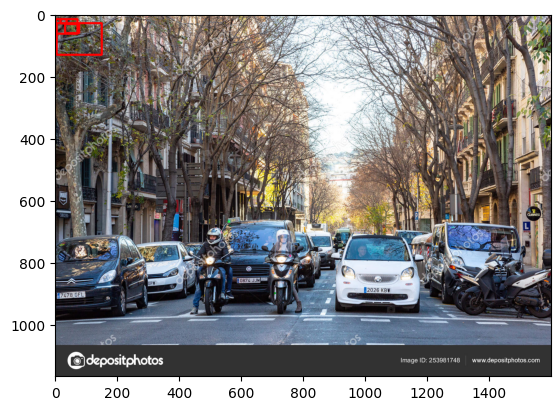

In [21]:
detections = outputs[0][idx]
rect = image.copy()

for detection in detections:
    conf = outputs[0][idx][-2]
    x, y, w, h = detection[:4].astype(int)
    x1, y1 = x-w//2, y-h//2
    x2, y2 = x+w//2, y+h//2
    x1 = x1 * width // 640
    y1 = y1 * height // 640
    x2 = x2 * width // 640
    y2 = y2 * height // 640
    top_left = (x1, y1)
    bottom_right = (x2, y2)
    rect = cv2.rectangle(rect, top_left, bottom_right, (255, 0, 0), 5)

plt.imshow(rect)
plt.show()

In [11]:
def getbbox(frame, width, height):
    blob = cv2.dnn.blobFromImage(frame, 1/255, (640, 640), swapRB=False, crop=False)
    net.setInput(blob)
    outputs = net.forward()
    idx = outputs[0][:, 4] > 0.80
    rect = frame.copy()
    detections = outputs[0][idx]
    
    for detection in detections:
        conf = detection[-2]
        x, y, w, h = detection[:4].astype(int)
        x1, y1 = x-w//2, y-h//2
        x2, y2 = x+w//2, y+h//2
        x1 = x1 * width // 640
        y1 = y1 * height // 640
        x2 = x2 * width // 640
        y2 = y2 * height // 640
        top_left = (x1, y1)
        bottom_right = (x2, y2)
        rect = cv2.rectangle(rect, top_left, bottom_right, (255, 0, 0), 5)
    
    return rect

In [22]:
cap = cv2.VideoCapture(DATA["video"])
assert cap.isOpened()

while (True):
    ret, frame = cap.read()
    height, width = frame.shape[:2]

    rect = getbbox(frame, width, height)

    cv2.imshow("Plate Detection", rect)

    if (cv2.waitKey(5) & 0xFF == 27):
        break

cap.release()
cv2.destroyAllWindows()